# H 4 Dashboard
 
Contract info can be found here: https://pennies.interactivebrokers.com/cstools/contract_info/v3.10/index.php 

## Setup data for Dashboard


In [222]:
class ContractWrapper:

    def __init__(self, reqId, contract):
        self.reqId = reqId
        self.contract = contract
        self.data = list()

    def info(self):
        return f"ReqId: {self.reqId} Contract: {self.contract} "

class Contracts:

    def __init__(self):
        self.contracts = dict()
        
    def info(self):
        return f"map: {self.contracts} "

    def add(self, contractWrapper: ContractWrapper):
        self.contracts[contractWrapper.reqId] = contractWrapper

# Initialise Contracts for the Dashboard        
eurusd = Contract()
eurusd.symbol = 'EUR'
eurusd.secType = 'CASH'
eurusd.exchange = 'IDEALPRO'
eurusd.currency = 'USD'
eurusdWrapper = ContractWrapper(1, eurusd)

eurzar = Contract()
eurzar.symbol = 'EUR'
eurzar.secType = 'CASH'
eurzar.exchange = 'IDEALPRO'
eurzar.currency = 'ZAR'
eurzarWrapper = ContractWrapper(2, eurzar)

"""
Contract: conId:320227571, 
	  symbol:QQQ, 
	  secType:STK 
	  primExchange:NASDAQ, 
	  currency:USD, 
	  derivativeSecTypes: CFD, 
	  description:INVESCO QQQ TRUST SERIES 1, issuerId:
"""
qqq = Contract()
qqq.conId = 320227571
qqq.symbol = 'QQQ'
qqq.secType = 'CFD'
qqq.exchange = 'NASDAQ'
qqq.currency = 'USD'
qqqWrapper = ContractWrapper(3, qqq)

es = Contract()
es.symbol = 'ES'
es.secType = 'FUT'
es.exchange = 'CME'
es.currency = 'USD'
es.lastTradeDateOrContractMonth = '20230616'
esWrapper = ContractWrapper(4, es)

indx = Contract()
indx.symbol = 'INDU'
indx.secType = 'IND'
indx.exchange = 'CME'
indx.currency = 'USD'
induWrapper = ContractWrapper(5, indx)

ndx = Contract()
ndx.symbol = 'NDX'
ndx.secType = 'IND'
ndx.exchange = 'NASDAQ'
ndx.currency = 'USD'
idxWrapper = ContractWrapper(6, ndx)


c = Contracts()
c.add(eurusdWrapper)
c.add(eurzarWrapper)
c.add(qqqWrapper)
c.add(esWrapper)
c.add(induWrapper)


## Define a callback for IB Historical data

In [166]:
def collectData(reqId, bar):
    c.contracts[reqId].data.append([bar.date, bar.open, bar.high, bar.low, bar.close])

## Connect to IB

In [223]:
from ibapi.client import EClient
from ibapi.wrapper import EWrapper  
from ibapi.contract import Contract
#from ibapi.contract import ListOfContractDescription

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from mplfinance import candlestick_ohlc
import mplfinance as mpf
import matplotlib.dates as mpl_dates

import threading
import time

class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)

    def tickPrice(self, reqId, tickType, price, attrib):
        if tickType == 2 and reqId == 1:
            print(tickType, ': The current ask price is: ', price)
    
    def historicalData(self, reqId, bar):        
        collectData(reqId, bar)

def run_loop():
    ib.run()

ib.disconnect()
ib = IBapi()
ib.connect('host.docker.internal', 7496, 3)

api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()
time.sleep(0.5)


ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:uscrypto
ERROR -1 2104 Market data farm connection is OK:usfuture.nj
ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:eufarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:euhmds
ERROR -1 2106 HMDS data farm connection is OK:ushmds.nj
ERROR -1 2106 HMDS data farm connection is OK:cashhmds
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefeu


## Request IB historical data

In [225]:
timeSpan = '4 D'
candleSize = '4 hours'
for k,v in c.contracts.items():
    print(f"Requesting historical data for {k} - {v.contract.symbol}_{v.contract.currency} ...")
    ib.reqHistoricalData(k, v.contract, '', timeSpan, candleSize, 'BID', 0, 2, False, [])

Requesting historical data for 1 - EUR_USD ...
Requesting historical data for 2 - EUR_ZAR ...
Requesting historical data for 3 - QQQ_USD ...
Requesting historical data for 4 - ES_USD ...
Requesting historical data for 5 - INDU_USD ...


ERROR 3 200 No security definition has been found for the request
ERROR 5 162 Historical Market Data Service error message:HMDS query returned no data: DJI@CME Bid


## Sanitise Data

In [ ]:
def get_df(data):    
    if not data:
        return None
    df = pd.DataFrame(data, columns=['DateTime','Open', 'High', 'Low', 'Close'])
    df['DateTime'] = pd.to_datetime(df['DateTime'],unit='s') 
    df = df.set_index('DateTime')
    df = df.tail(6)
    return df

## Plot 

1 EUR, data.size: 56
2 EUR, data.size: 56
3 QQQ, data.size: 0
4 ES, data.size: 56
5 INDU, data.size: 0


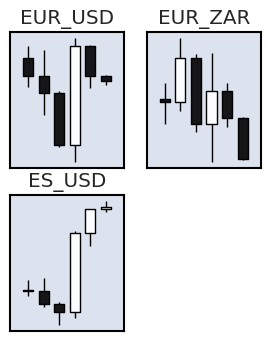

ERROR -1 2103 Market data farm connection is broken:cashfarm
ERROR -1 2103 Market data farm connection is broken:cashfarm
ERROR -1 2103 Market data farm connection is broken:cashfarm
ERROR -1 2103 Market data farm connection is broken:cashfarm
ERROR -1 2103 Market data farm connection is broken:cashfarm
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2103 Market data farm connection is broken:usfuture.nj
ERROR -1 2104 Market data farm connection is OK:usfuture.nj
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture.nj
ERROR -1 2104 Market data farm connection is OK:usfuture.nj
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2104 Market data farm connection is OK:usfuture


In [230]:
fig = mpf.figure(figsize=(5,6))

for k,v in c.contracts.items():    
    print(f"{k} {v.contract.symbol}, data.size: {len(v.data)}")
    if v.data:
        #print(f"{k} {v.contract.symbol}{v.data}")
        ax1 = fig.add_subplot(3,3,k)
        ax1.axes.xaxis.set_visible(False)
        ax1.axes.yaxis.set_visible(False)
        mpf.plot(get_df(v.data),ax=ax1, type='candle', axtitle=v.contract.symbol+'_'+v.contract.currency)


<class 'mplfinance._mplwraps.Mpf_Figure'>


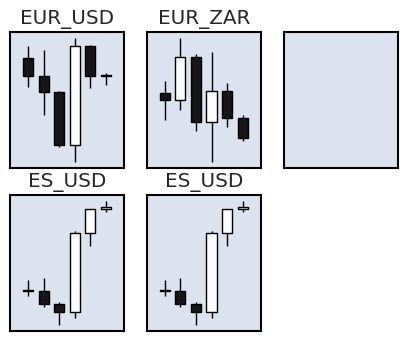

ERROR -1 2105 HMDS data farm connection is broken:cashhmds
ERROR -1 2106 HMDS data farm connection is OK:cashhmds
ERROR -1 2103 Market data farm connection is broken:cashfarm
ERROR -1 2103 Market data farm connection is broken:cashfarm
ERROR -1 2103 Market data farm connection is broken:cashfarm
ERROR -1 2103 Market data farm connection is broken:cashfarm
ERROR -1 2103 Market data farm connection is broken:cashfarm
ERROR -1 2103 Market data farm connection is broken:cashfarm
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2104 Market data farm connection is OK:usfuture


In [208]:


fig = mpf.figure(figsize=(5,6))
print(type(fig))

#for k,v in c.contracts.items():    
ax1 = fig.add_subplot(3,3,1)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)

ax2 = fig.add_subplot(3,3,2)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)

ax3 = fig.add_subplot(3,3,3)
ax3.axes.xaxis.set_visible(False)
ax3.axes.yaxis.set_visible(False)

ax4 = fig.add_subplot(3,3,4)
ax4.axes.xaxis.set_visible(False)
ax4.axes.yaxis.set_visible(False)

ax5 = fig.add_subplot(3,3,5)
ax5.axes.xaxis.set_visible(False)
ax5.axes.yaxis.set_visible(False)

mpf.plot(get_df(c.contracts[1].data),ax=ax1, type='candle', axtitle=c.contracts[1].contract.symbol+'_'+c.contracts[1].contract.currency)
mpf.plot(get_df(c.contracts[2].data),ax=ax2, type='candle', axtitle=c.contracts[2].contract.symbol+'_'+c.contracts[2].contract.currency)
if len(c.contracts[3].data) > 0:
    mpf.plot(get_df(c.contracts[3].data),ax=ax3, type='candle', axtitle=c.contracts[3].contract.symbol+'_'+c.contracts[3].contract.currency)
mpf.plot(get_df(c.contracts[4].data),ax=ax4, type='candle', axtitle=c.contracts[4].contract.symbol+'_'+c.contracts[3].contract.currency)
mpf.plot(get_df(c.contracts[4].data),ax=ax5, type='candle', axtitle=c.contracts[4].contract.symbol+'_'+c.contracts[3].contract.currency)

#mpf.plot(get_df(tickers["EURZAR"]),ax=ax2, axtitle='EURZAR')
#mpf.plot(df,ax=ax3,axtitle='XXX')
#mpf.plot(df,ax=ax4,axtitle='X')


#mpf.plot(df,ax=ax1)
#fig


In [99]:
ib.disconnect()